In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Undergraduate_Thesis_Duncan/data

Mounted at /gdrive
/gdrive/MyDrive/Undergraduate_Thesis_Duncan/data


# Imports

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.dpi"] = 144
import seaborn as sns
import time
import itertools
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

In [ ]:
import statsmodels.formula.api as smf 
import statsmodels.api as sm
from statsmodels.tools import eval_measures

# Submission Code

In [ ]:
import os
def createSubmission(sj,iq,name):
  path='/gdrive/MyDrive/Undergraduate_Thesis_Duncan/submissions'
  name = name + ".csv"
  path = os.path.join(path,name)
  df_submission = pd.read_csv("submission_format.csv")
  df_submission.total_cases = np.concatenate([sj,iq])
  df_submission.to_csv(path,index=False)

# Data Preprocessing

## Normalization function

In [ ]:
def normalize(df):
    result = df.copy()
    norms = ["reanalysis_air_temp_k","reanalysis_avg_temp_k","reanalysis_dew_point_temp_k","reanalysis_max_air_temp_k","reanalysis_min_air_temp_k","reanalysis_tdtr_k","station_avg_temp_c","station_diur_temp_rng_c","station_max_temp_c","station_min_temp_c","precipitation_amt_mm","reanalysis_precip_amt_kg_per_m2","reanalysis_relative_humidity_percent","reanalysis_sat_precip_amt_mm","reanalysis_specific_humidity_g_per_kg","station_precip_mm"]
    for feature_name in norms:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

## Standardization function

In [ ]:
def standardize(df):
  modify = df.copy()
  modify = StandardScaler().fit_transform(modify)

  result = df.copy()
  stans = ["reanalysis_precip_amt_kg_per_m2","reanalysis_relative_humidity_percent","reanalysis_sat_precip_amt_mm","reanalysis_specific_humidity_g_per_kg","station_precip_mm"]
  for feature_name in stans:
    result[feature_name] = modify[feature_name]
  return result

## Fix NaN function

In [ ]:
def fixNulls(df):
  result = df.copy()
  for col in df.columns:
    if(col != "city"):
      # first try to fill NaN with mean() values from that week of year across our dataset
      # i.e replace null values from a row on week 2 with mean values in week 2 across dataset
      df[col] = df.groupby('weekofyear')[col].apply(lambda x: x.fillna(x.mean()))

      #if value is still null (because all values for that week are null) replace with column mean
      df[col] = df[col].fillna(df[col].mean())
  
  return df

## Correlation Work

In [ ]:
def check_correlations(df): #train
  for colA in df.columns:
    for colB in df.columns:
      if colA in df and colB in df:
        correlation = df[colA].corr(df[colB])
        if colA != colB and correlation > .65:
            df.drop(colB,axis=1, inplace=True)

  return df

In [ ]:
def select_correlation_columns(dfA,dfB): #test data
  for col in dfB:
    if col not in dfA:
      dfB.drop(col,axis=1,inplace=True)
  return dfB

## Preprocess Driver function

In [ ]:
def preprocess_input(path,norm,stand,impute):
  df = pd.read_csv(path)
  if norm:
    df = normalize(df)
  df.drop('week_start_date', axis=1,inplace=True)

  sj = df.loc[df['city'] == 'sj']
  iq = df.loc[df['city'] == 'iq']
  sj.drop('city', axis=1,inplace=True)
  iq.drop('city', axis=1,inplace=True)

  if not impute:
    sj = fixNulls(sj)
    iq = fixNulls(iq)

  if stand:
    sj = standardize(sj)
    iq = standardize(iq)

  return sj,iq,df

In [ ]:
sj_train, iq_train,total = preprocess_input("dengue_features_train.csv",True,False,False)


#sj_train, iq_train = check_correlations(sj_train), check_correlations(iq_train)
#sj_train.head()
total.describe()
x = pd.concat([sj_train,iq_train])
x.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000
mean,2001.031593,26.503434,0.131372,0.128595,0.203527,0.201866,0.116845,0.537319,0.538990,0.635981,0.347304,0.678160,0.070333,0.597034,0.116845,0.574954,0.241852,0.615638,0.318572,0.371403,0.678631,0.072748,24.675137
std,5.408314,15.019437,0.134417,0.118560,0.073384,0.083452,0.111568,0.179594,0.156578,0.173023,0.199634,0.197053,0.075906,0.174909,0.111568,0.175938,0.241684,0.136108,0.190199,0.126197,0.143918,0.086866,43.596000
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1997.000000,13.750000,0.044025,0.050425,0.155549,0.144639,0.025416,0.400472,0.418667,0.508110,0.197531,0.538462,0.023138,0.476186,0.025416,0.438950,0.066212,0.524316,0.177440,0.283871,0.587156,0.016289,5.000000
50%,2002.000000,26.500000,0.105690,0.115133,0.195664,0.187779,0.097721,0.529462,0.546222,0.679319,0.283951,0.715385,0.047853,0.551179,0.097721,0.613852,0.102240,0.639818,0.250317,0.393548,0.688073,0.045003,12.000000
75%,2005.000000,39.250000,0.230950,0.213429,0.247735,0.246775,0.179333,0.686355,0.661333,0.773601,0.475309,0.846154,0.091499,0.701821,0.179333,0.715657,0.428676,0.715805,0.463799,0.464516,0.788991,0.100359,28.000000
max,2010.000000,53.000000,0.508357,0.454429,0.538314,0.546017,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,461.000000


In [ ]:

x2 = pd.concat([total.groupby('weekofyear').mean().head(),total.groupby('weekofyear').mean().tail()])
x2
path='/gdrive/MyDrive/Undergraduate_Thesis_Duncan/submissions'
name = "GROUPED_MEAN.csv"
path = os.path.join(path,name)
x2.to_csv(path,index=True)

In [ ]:
sj_test, iq_test,test = preprocess_input("dengue_features_test.csv",True,False,False)
#sj_test, iq_test = select_correlation_columns(sj_train,sj_test), select_correlation_columns(iq_train,iq_test)

In [ ]:
sj_train_2, iq_train_2 ,total_2 = preprocess_input("imputed.csv",True,False,True)
sj_train_2.dropna(inplace=True)
iq_train_2.dropna(inplace=True)
total_2.dropna(inplace=True)
total_2.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000
mean,2001.044352,26.538462,0.130925,0.128815,0.203206,0.201841,0.117154,0.537813,0.539514,0.636598,0.347809,0.678357,0.070479,0.597262,0.117154,0.575599,0.242091,0.615897,0.318635,0.371614,0.679166,0.072884,24.613999
std,5.394375,14.906798,0.139828,0.120403,0.074584,0.084180,0.111919,0.180199,0.157005,0.173444,0.199619,0.197532,0.076180,0.175351,0.111919,0.176321,0.241850,0.136723,0.190833,0.126134,0.144422,0.088181,43.713177
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1997.000000,14.000000,0.035450,0.048200,0.153986,0.143071,0.025090,0.399717,0.419556,0.508516,0.197531,0.538462,0.022910,0.475084,0.025090,0.439726,0.066212,0.524126,0.177440,0.283871,0.587156,0.015921,5.000000
50%,2002.000000,27.000000,0.116100,0.118525,0.195914,0.188229,0.098157,0.530500,0.547556,0.681265,0.283951,0.715385,0.047853,0.551547,0.098157,0.615158,0.102240,0.639818,0.252218,0.393548,0.688073,0.044174,12.000000
75%,2005.000000,39.000000,0.233300,0.214008,0.248792,0.246964,0.179813,0.687630,0.661333,0.774128,0.475309,0.846154,0.091762,0.701078,0.179813,0.716269,0.427945,0.718845,0.454373,0.464516,0.788991,0.099577,28.000000
max,2010.000000,52.000000,0.508357,0.454429,0.538314,0.546017,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,461.000000


In [ ]:
sj_train_2.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.00000
mean,1998.851133,26.559871,0.056652,0.067419,0.176903,0.165384,0.090811,0.599211,0.546108,0.621208,0.222455,0.800473,0.053501,0.509041,0.090811,0.553554,0.079031,0.596892,0.197753,0.316595,0.725265,0.049409,34.08630
std,5.207721,14.911562,0.106420,0.093514,0.058276,0.056444,0.114199,0.163355,0.151599,0.178273,0.077637,0.099561,0.062524,0.083060,0.114199,0.178477,0.034051,0.150603,0.074245,0.110760,0.138138,0.054028,51.57143
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,0.172238,0.152000,0.000000,0.000000,0.438462,0.000000,0.219205,0.000000,0.000000,0.000000,0.153495,0.000000,0.000000,0.284404,0.000000,0.00000
25%,1994.000000,14.000000,0.004133,0.016550,0.138729,0.128111,0.000000,0.471010,0.425333,0.477940,0.160494,0.723077,0.019018,0.452180,0.000000,0.403545,0.054528,0.472644,0.148289,0.251613,0.642202,0.012608,9.00000
50%,1999.000000,27.000000,0.056800,0.068650,0.176786,0.165729,0.053251,0.612653,0.559111,0.661314,0.228395,0.815385,0.037511,0.511513,0.053251,0.587063,0.074976,0.621581,0.197719,0.322581,0.743119,0.032763,19.00000
75%,2003.000000,39.000000,0.112050,0.115200,0.212386,0.202555,0.133589,0.727101,0.664444,0.769505,0.283951,0.884615,0.064943,0.567592,0.133589,0.703038,0.098345,0.722644,0.244613,0.393548,0.844037,0.065433,37.00000
max,2008.000000,52.000000,0.493400,0.437100,0.393129,0.381420,1.000000,1.000000,0.904889,0.925710,0.401235,1.000000,1.000000,0.729703,1.000000,0.883208,0.209348,0.922492,0.477820,0.574194,1.000000,0.563041,461.00000


In [ ]:
iq_train_2.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000
mean,2004.984496,26.500000,0.264358,0.239114,0.250461,0.267336,0.164480,0.427512,0.527668,0.664248,0.573009,0.458974,0.100981,0.755752,0.164480,0.615204,0.535029,0.650039,0.535801,0.470455,0.596348,0.115056,7.596899
std,2.915601,14.912626,0.081325,0.076767,0.077372,0.086155,0.090166,0.154806,0.165769,0.160918,0.147098,0.127928,0.088145,0.185776,0.090166,0.165312,0.166891,0.098693,0.136020,0.085157,0.115729,0.117261,10.796813
min,2000.000000,1.000000,0.061729,0.035860,0.029880,0.064183,0.000000,0.000000,0.000000,0.050608,0.135802,0.000000,0.000000,0.000000,0.000000,0.045247,0.160662,0.000000,0.059569,0.219355,0.000000,0.000000,0.000000
25%,2002.000000,14.000000,0.200150,0.180260,0.194748,0.205246,0.100115,0.324788,0.414222,0.562165,0.456790,0.390385,0.042182,0.649339,0.100115,0.501633,0.409932,0.595080,0.441065,0.419355,0.541284,0.031290,1.000000
50%,2005.000000,26.500000,0.265379,0.233593,0.250129,0.262429,0.154813,0.421341,0.526222,0.705028,0.570988,0.473077,0.081402,0.811555,0.154813,0.653218,0.518500,0.659574,0.539766,0.470968,0.610092,0.083011,5.000000
75%,2007.000000,39.000000,0.320246,0.293989,0.303396,0.325432,0.219553,0.530595,0.650889,0.784104,0.672840,0.561538,0.124579,0.900887,0.219553,0.739178,0.658228,0.712766,0.632034,0.524194,0.669725,0.158200,9.000000
max,2010.000000,52.000000,0.508357,0.454429,0.538314,0.546017,0.539759,0.925590,1.000000,1.000000,1.000000,0.700000,0.634584,1.000000,0.539759,1.000000,1.000000,1.000000,1.000000,1.000000,0.871560,1.000000,116.000000


In [ ]:
  #EXPORT SUMMARY DATA TO CSV
  path='/gdrive/MyDrive/Undergraduate_Thesis_Duncan/submissions'
  name = "SUMMARY_DATA.csv"
  path = os.path.join(path,name)
  total.describe().to_csv(path,index=True)
  
  name = "SUMMARY_DATA_IMPUTED.csv"
  path='/gdrive/MyDrive/Undergraduate_Thesis_Duncan/submissions'
  path = os.path.join(path,name)
  total_2.describe().to_csv(path,index=True)

  name = "SUMMARY_DATA_GROUP_AVG .csv"
  path='/gdrive/MyDrive/Undergraduate_Thesis_Duncan/submissions'
  path = os.path.join(path,name)
  x.describe().to_csv(path,index=True)

In [ ]:
reduced_train_sj = sj_train[['year', 'weekofyear', 'ndvi_se','total_cases']].copy()
reduced_train_iq = iq_train[['year', 'weekofyear', 'ndvi_se','total_cases']].copy()

In [ ]:
reduced_train_sj_2 = sj_train_2[['year', 'weekofyear', 'ndvi_se','total_cases']].copy()
reduced_train_iq_2 = iq_train_2[['year', 'weekofyear', 'ndvi_se','total_cases']].copy()

In [ ]:
reduced_test_sj = sj_test[['year', 'weekofyear', 'ndvi_se']].copy()
reduced_test_iq = iq_test[['year', 'weekofyear', 'ndvi_se']].copy()

# Model 1 -- Negative Binomial


## Find best equation for Model 1


In [ ]:
def bestModel(X_train, X_test):
  eq = "total_cases ~ 1"
  bestScore = 1000000
  bestModel = None
  usedCol = ['total_cases']
  

  for x in range(len(X_train.columns)):
    testScore = bestScore
    curr_eq = ""
    testModel = None

    for col in X_train.columns:
      if col in usedCol:
        continue
      test_eq = eq + " + " + col
      model = smf.glm(formula = test_eq, data=X_train, family=sm.families.NegativeBinomial()).fit()
      predictions = model.predict(X_test).astype(int)
      score = eval_measures.meanabs(predictions, X_test.total_cases)
      if score < testScore:
        testScore = score
        curr_eq = test_eq
        testModel = model

    if testScore < bestScore:
      bestScore = testScore
      eq = curr_eq
      bestModel = testModel
      usedCol.append(col)
    else:
      break
  
  return eq, bestScore, bestModel

In [ ]:
def saturatedModel(X_train, X_test):
  eq = "total_cases ~ 1"
  usedCol = ['total_cases']

  for col in X_train.columns:
      if col not in usedCol:
        eq = eq + " + " + col
        usedCol.append(col)
  
  model = smf.glm(formula = eq, data=X_train, family=sm.families.NegativeBinomial()).fit()
  predictions = model.predict(X_test).astype(int)
  score = eval_measures.meanabs(predictions, X_test.total_cases)

  return score, model

## Fit for SJ Data

In [ ]:
X_train, X_test = train_test_split(sj_train, test_size=0.33, random_state=42)
sj_eq, sj_score, sj_model = bestModel(X_train, X_test)
print(sj_score)
print(sj_eq)
sj_model.summary()
sj_model.aic

23.540453074433657
total_cases ~ 1 + weekofyear + year + reanalysis_max_air_temp_k + station_avg_temp_c + ndvi_ne + ndvi_sw + reanalysis_air_temp_k + station_min_temp_c + reanalysis_avg_temp_k + station_diur_temp_rng_c


5489.00847561913

In [ ]:
X_train, X_test = train_test_split(sj_train_2, test_size=0.33, random_state=42)
sj_eq, sj_score, sj_model = bestModel(X_train, X_test)
print(sj_score)
print(sj_eq)
sj_model.summary()
sj_model.aic

21.81045751633987
total_cases ~ 1 + weekofyear + year + reanalysis_max_air_temp_k + station_avg_temp_c + ndvi_ne + ndvi_se + station_max_temp_c + reanalysis_relative_humidity_percent


5477.830369213732

## Fit for IQ Data

In [ ]:
X_train, X_test = train_test_split(iq_train, test_size=0.33, random_state=42)
iq_eq, iq_score, iq_model = bestModel(X_train, X_test)
print(iq_score)
print(iq_eq)
iq_model.summary()
iq_model.aic

6.017441860465116
total_cases ~ 1 + year + reanalysis_tdtr_k + precipitation_amt_mm


2143.3666125592163

In [ ]:
X_train, X_test = train_test_split(iq_train_2, test_size=0.33, random_state=42)
iq_eq, iq_score, iq_model = bestModel(X_train, X_test)
print(iq_score)
print(iq_eq)
iq_model.summary()
iq_model.aic

5.678362573099415
total_cases ~ 1 + year + reanalysis_relative_humidity_percent + reanalysis_precip_amt_kg_per_m2 + ndvi_ne + ndvi_se + station_diur_temp_rng_c


2129.9606841252794

## Fits for submission

In [ ]:
#SJ IMPUTED
X_train, X_test = train_test_split(sj_train_2, test_size=0.33, random_state=42)
sj_score, sj_model = saturatedModel(X_train, X_test)
print("MAE",sj_score)
sj_model.aic

MAE 24.598705501618124


5491.910529928943

In [ ]:
#SJ GROUPED
X_train, X_test = train_test_split(sj_train, test_size=0.33, random_state=42)
sj_score, sj_model = saturatedModel(X_train, X_test)
print("MAE",sj_score)
sj_model.aic

MAE 24.598705501618124


5491.910529928943

In [ ]:
#IQ IMPUTED
X_train, X_test = train_test_split(iq_train_2, test_size=0.33, random_state=42)
iq_score, iq_model = saturatedModel(X_train, X_test)
print("MAE",iq_score)
iq_model.aic

MAE 6.678362573099415


2093.2159224794023

In [ ]:
#IQ GROUPED
X_train, X_test = train_test_split(iq_train, test_size=0.33, random_state=42)
iq_score, iq_model = saturatedModel(X_train, X_test)
print("MAE",iq_score)
iq_model.aic

MAE 6.616279069767442


2111.5963475455246

## Submit Model 1

In [ ]:
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")
change = input("Enter change title: ")
name = "submission1_nb_" + change + "_" + dt_string

createSubmission(sj_model.predict(sj_test).astype(int),iq_model.predict(iq_test).astype(int),name)

KeyboardInterrupt: ignored

# Model 2 -- DNN

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

## Model Layers and set up

In [ ]:
def build_and_compile_model(norm, n, l,shape):
  model = None
  if l is 2:
    model = keras.Sequential([
        tf.keras.layers.Input(shape=shape),
        tf.keras.layers.Dense(n, activation='relu'),
        tf.keras.layers.Dropout(.2),
        tf.keras.layers.Dense(n/2, activation='relu'),
        tf.keras.layers.Dropout(.2),
        tf.keras.layers.Dense(1)
      ])
  else:
    model = keras.Sequential([
        tf.keras.layers.Input(shape=shape),
        tf.keras.layers.Dense(n, activation='relu'),
        tf.keras.layers.Dropout(.2),
        tf.keras.layers.Dense(n/2, activation='relu'),
        tf.keras.layers.Dropout(.2),
        tf.keras.layers.Dense(n/4, activation='relu'),
        tf.keras.layers.Dropout(.2),
        tf.keras.layers.Dense(1)
      ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

## Model building

In [ ]:
def build_DNN_model(df):
  X = df.copy()
  y = X.pop('total_cases')
  
  normalizer = preprocessing.Normalization(axis=-1)
  normalizer.adapt(np.array(X))
  params = [64,128,256]
  layers = [2]
  bestModel = None
  bestScore = 1000000
  
  for l in layers:
   for n in params:
     X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.85,random_state=42)
     dnn_model = build_and_compile_model(normalizer,n,l,X_train.shape[-1])
     reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="mae", factor=0.8, patience=3, min_lr=1e-6, verbose=1,
                                                      mode="max")
     %%time
     history = dnn_model.fit(X_train, y_train, validation_split=0.15, verbose=1, epochs=40,steps_per_epoch=200,callbacks=[reduce_lr])
     score = dnn_model.evaluate(X_test, y_test, verbose=1)
     
     if(score < bestScore):
      bestModel = dnn_model
      bestScore = score
      bestParams = [n,l]

  
  return bestScore, bestModel, bestParams

## Fit for SJ

In [ ]:
sj_dnn_score, sj_dnn_model, sj_dnn_params = build_DNN_model(sj_train)
print(sj_dnn_score)
print("best n: " + str(sj_dnn_params[0]))
print("best l: " + str(sj_dnn_params[1]))
sj_dnn_model.summary()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs
Epoch 1/40
200/200 [==============================] - 1s 2ms/step - loss: 68.8525 - val_loss: 24.3791 - lr: 0.0010
Epoch 2/40
200/200 [==============================] - 0s 2ms/step - loss: 34.1994 - val_loss: 17.3802 - lr: 0.0010
Epoch 3/40
200/200 [==============================] - 0s 2ms/step - loss: 28.2113 - val_loss: 17.5576 - lr: 0.0010
Epoch 4/40
200/200 [==============================] - 0s 2ms/step - loss: 30.7099 - val_loss: 17.6155 - lr: 0.0010
Epoch 5/40
200/200 [==============================] - 0s 2ms/step - loss: 28.3357 - val_loss: 17.4087 - lr: 0.0010
Epoch 6/40
200/200 [==============================] - 0s 2ms/step - loss: 27.5763 - val_loss: 17.7070 - lr: 0.0010
Epoch 7/40
200/200 [==============================] - 0s 2ms/step - loss: 28.8721 - val_loss: 16.9590 - lr: 0.0010
Epoch 8/40
200/200 [==============================] - 0s 2ms/step - loss: 29.1643 - val_loss: 17.7189 - lr: 0.0010
Epoch 9/40
200/2

In [ ]:
sj_dnn_score, sj_dnn_model, sj_dnn_params = build_DNN_model(sj_train_2)
print(sj_dnn_score)
print("best n: " + str(sj_dnn_params[0]))
print("best l: " + str(sj_dnn_params[1]))
sj_dnn_model.summary()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs
Epoch 1/40
200/200 [==============================] - 1s 2ms/step - loss: 83.8751 - val_loss: 17.9471 - lr: 0.0010
Epoch 2/40
200/200 [==============================] - 0s 2ms/step - loss: 38.0713 - val_loss: 17.4134 - lr: 0.0010
Epoch 3/40
200/200 [==============================] - 0s 2ms/step - loss: 30.5023 - val_loss: 16.8422 - lr: 0.0010
Epoch 4/40
200/200 [==============================] - 0s 2ms/step - loss: 28.4975 - val_loss: 17.2403 - lr: 0.0010
Epoch 5/40
200/200 [==============================] - 0s 2ms/step - loss: 28.5710 - val_loss: 18.0413 - lr: 0.0010
Epoch 6/40
200/200 [==============================] - 0s 2ms/step - loss: 27.2737 - val_loss: 16.8370 - lr: 0.0010
Epoch 7/40
200/200 [==============================] - 0s 2ms/step - loss: 27.3515 - val_loss: 17.0695 - lr: 0.0010
Epoch 8/40
200/200 [==============================] - 0s 2ms/step - loss: 28.8686 - val_loss: 17.2578 - lr: 0.0010
Epoch 9/40
200/2

## Fit for IQ

In [ ]:
iq_dnn_score, iq_dnn_model,iq_dnn_params = build_DNN_model(iq_train)
print(iq_dnn_score)
print("best n: " + str(iq_dnn_params[0]))
print("best l: " + str(iq_dnn_params[1]))
iq_dnn_model.summary()

In [ ]:
iq_dnn_score, iq_dnn_model,iq_dnn_params = build_DNN_model(iq_train_2)
print(iq_dnn_score)
print("best n: " + str(iq_dnn_params[0]))
print("best l: " + str(iq_dnn_params[1]))
iq_dnn_model.summary()

## Submit Model 2

In [ ]:
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")
change = input("Enter change title: ")
name = "submission2_dnn_" + change + "_" + dt_string

createSubmission(sj_dnn_model.predict(sj_test).astype(int),iq_dnn_model.predict(iq_test).astype(int),name)

Enter change title: noNorm-Imputed


# Model 3 -- Random Forest

## Build Model

In [54]:
from sklearn.ensemble import RandomForestRegressor

In [56]:
def build_RF_ensemble(df,treeCounts):
  X = df.copy()
  y = X.pop('total_cases')
  X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.70,random_state = 42)
  
  bestModel = None
  bestScore = 1000000
  bestCount = 0

  for n in treeCounts:
    # Instantiate model with n decision trees
    rf = RandomForestRegressor(n_estimators = n, random_state = 42)

    # Train the model on training data
    rf.fit(X_train, y_train);
    predictions = rf.predict(X_test)
    rf_MAE = eval_measures.meanabs(predictions, y_test)
    print(n, rf_MAE)

    if(rf_MAE < bestScore):
      bestScore = rf_MAE
      bestModel = rf
      bestCount = n



  return bestScore, bestModel, bestCount

## Fit for SJ

In [57]:
treeCounts = [50,100,250,500,1000]

In [ ]:
sj_rf_score, sj_rf_model, sj_rf_treeCount = build_RF_ensemble(sj_train,treeCounts)
print(sj_rf_score)
print("tree count: "+ str(sj_rf_treeCount))

50 17.913167259786476
100 17.655231316725978
250 17.223444839857653
500 17.176690391459076
1000 17.310839857651246
17.176690391459076
tree count: 500


In [ ]:
sj_rf_score, sj_rf_model, sj_rf_treeCount = build_RF_ensemble(sj_train_2,treeCounts)
print(sj_rf_score)
print("tree count: "+ str(sj_rf_treeCount))

50 18.489247311827956
100 17.663727598566307
250 17.265906810035844
500 17.233232974910393
1000 17.197806451612905
17.197806451612905
tree count: 1000


<BarContainer object of 22 artists>

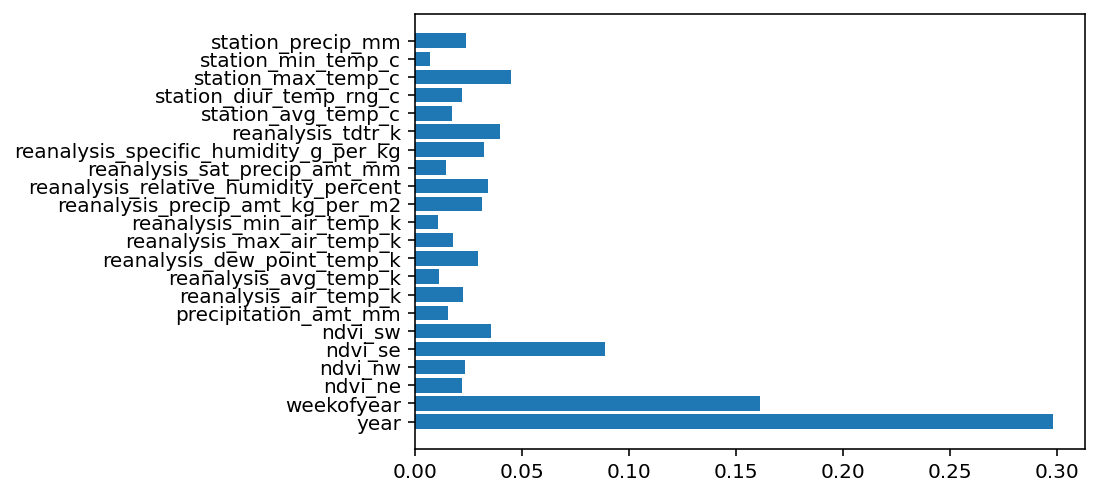

In [ ]:
x = sj_train.columns
x=x.drop('total_cases')
x = x.values
plt.barh(x, sj_rf_model.feature_importances_)


In [ ]:
sj_rf_model.feature_importances_

array([0.29802116, 0.16102316, 0.02183101, 0.02323211, 0.08855248,
       0.03528769, 0.01548138, 0.02218517, 0.0112989 , 0.0293977 ,
       0.01749438, 0.01084786, 0.03100211, 0.03396758, 0.014357  ,
       0.03190629, 0.03952549, 0.01703885, 0.02185915, 0.04492127,
       0.00684855, 0.02392071])

In [ ]:
out = pd.DataFrame({'labels':x, 'values':sj_rf_model.feature_importances_})
out

In [ ]:
path='/gdrive/MyDrive/Undergraduate_Thesis_Duncan/submissions'
name = "bargraph.csv"
path = os.path.join(path,name)
out.to_csv(path,index=False)

In [63]:
sj_rf_score, sj_rf_model, sj_rf_treeCount = build_RF_ensemble(reduced_train_sj,treeCounts)
print(sj_rf_score)
print("tree count: "+ str(sj_rf_treeCount))

50 10.19067615658363
100 10.135124555160141
250 10.187886120996438
500 10.370697508896798
1000 10.399758007117438
10.135124555160141
tree count: 100


In [65]:
sj_rf_score, sj_rf_model, sj_rf_treeCount = build_RF_ensemble(reduced_train_sj_2,treeCounts)
print(sj_rf_score)
print("tree count: "+ str(sj_rf_treeCount))

50 11.049605734767026
100 11.228960573476703
250 11.314408602150538
500 11.314078853046595
1000 11.283594982078851
11.049605734767026
tree count: 50


## Fit for IQ

In [ ]:
iq_rf_score, iq_rf_model,iq_rf_treeCount = build_RF_ensemble(iq_train,treeCounts)
print(iq_rf_score)
print("tree count: "+ str(iq_rf_treeCount))

50 6.128589743589743
100 6.00275641025641
250 5.987589743589744
500 5.950217948717948
1000 5.9518589743589745
5.950217948717948
tree count: 500


In [ ]:
iq_rf_score, iq_rf_model,iq_rf_treeCount = build_RF_ensemble(iq_train_2,treeCounts)
print(iq_rf_score)
print("tree count: "+ str(iq_rf_treeCount))

50 5.861806451612903
100 5.77232258064516
250 5.800309677419355
500 5.7712387096774185
1000 5.771645161290322
5.7712387096774185
tree count: 500


In [ ]:
sj_rf_model.get_params()

In [62]:
iq_rf_score, iq_rf_model,iq_rf_treeCount = build_RF_ensemble(reduced_train_iq,treeCounts)
print(iq_rf_score)
print("tree count: "+ str(iq_rf_treeCount))

50 4.968076923076923
100 4.839358974358975
250 4.946512820512821
500 4.927423076923077
1000 4.94225
4.839358974358975
tree count: 100


In [66]:
iq_rf_score, iq_rf_model,iq_rf_treeCount = build_RF_ensemble(reduced_train_iq_2,treeCounts)
print(iq_rf_score)
print("tree count: "+ str(iq_rf_treeCount))

50 5.110322580645161
100 4.955225806451613
250 4.892103225806452
500 4.7904
1000 4.788522580645162
4.788522580645162
tree count: 1000


## Submit Model 3

In [68]:
total.corr()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
year,1.000000,-0.071649,0.223361,0.144345,0.234234,0.277759,0.205302,-0.140016,0.085043,0.132273,0.480402,-0.392351,0.132625,0.336349,0.205302,0.161596,0.490542,0.047010,0.373644,0.227320,-0.214482,0.219910,-0.306806
weekofyear,-0.071649,1.000000,0.053548,0.048759,0.121557,0.068701,0.118037,0.425753,0.463677,0.348946,0.238078,0.179679,0.072955,-0.015191,0.118037,0.350821,0.077933,0.368408,0.023220,0.232098,0.292362,0.066294,0.216452
ndvi_ne,0.223361,0.053548,1.000000,0.850902,0.614380,0.669504,0.205736,-0.340976,-0.037682,0.056077,0.634330,-0.623116,0.199411,0.457985,0.205736,0.094852,0.673935,0.186227,0.658129,0.491922,-0.315696,0.242263,-0.241376
ndvi_nw,0.144345,0.048759,0.850902,1.000000,0.555809,0.651938,0.193563,-0.317862,-0.030974,0.063289,0.606775,-0.588806,0.190989,0.449152,0.193563,0.100626,0.645596,0.203975,0.649483,0.490122,-0.304206,0.221314,-0.202235
ndvi_se,0.234234,0.121557,0.614380,0.555809,1.000000,0.820924,0.074633,-0.157447,0.051348,0.002810,0.468054,-0.407931,0.034792,0.215606,0.074633,0.028795,0.486047,0.089242,0.449599,0.290691,-0.251621,0.131326,-0.168612
ndvi_sw,0.277759,0.068701,0.669504,0.651938,0.820924,1.000000,0.124047,-0.227824,0.022533,0.020746,0.546460,-0.494284,0.101652,0.311759,0.124047,0.053437,0.569554,0.121060,0.545899,0.377393,-0.294684,0.158345,-0.196461
precipitation_amt_mm,0.205302,0.118037,0.205736,0.193563,0.074633,0.124047,1.000000,-0.017229,0.106384,0.434722,0.282721,-0.119691,0.481159,0.499984,1.000000,0.451202,0.201427,0.225408,0.193358,0.296215,0.076680,0.486637,-0.038740
reanalysis_air_temp_k,-0.140016,0.425753,-0.340976,-0.317862,-0.157447,-0.227824,-0.017229,1.000000,0.901777,0.529771,-0.001211,0.736765,-0.128219,-0.402338,-0.017229,0.508380,-0.280375,0.619974,-0.261457,0.227768,0.719612,-0.173851,0.264952
reanalysis_avg_temp_k,0.085043,0.463677,-0.037682,-0.030974,0.051348,0.022533,0.106384,0.901777,1.000000,0.614268,0.398224,0.436689,-0.031728,-0.168371,0.106384,0.612484,0.124200,0.751330,0.107581,0.512220,0.579864,-0.048052,0.151637
reanalysis_dew_point_temp_k,0.132273,0.348946,0.056077,0.063289,0.002810,0.020746,0.434722,0.529771,0.614268,1.000000,0.257380,0.361781,0.432970,0.553766,0.434722,0.997051,-0.033512,0.743506,0.037151,0.492319,0.651535,0.241335,0.142531


In [ ]:
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")
change = input("Enter change title: ")
name = "submission3_rf_" + change + "_" + dt_string

createSubmission(sj_rf_model.predict(sj_test).astype(int),iq_rf_model.predict(iq_test).astype(int),name)

Enter change title: tree_count_loop2


In [67]:
#reduced model
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")
change = input("Enter change title: ")
name = "submission3_rf_" + change + "_" + dt_string

createSubmission(sj_rf_model.predict(reduced_test_sj).astype(int),iq_rf_model.predict(reduced_test_iq).astype(int),name)

Enter change title: rf red 2


# Model 4 -- XGBoost

## Build Model

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

def build_XGBoost_model(df):
 

  X = df.copy()
  y = X.pop('total_cases')
  X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.70,random_state = 42)

  model = XGBRegressor(n_estimators=50, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
  # define model evaluation method
  #cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
  # evaluate model
  #scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
  # force scores to be positive
 # scores = absolute(scores)
 # print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
  model.fit(X_train,y_train)


  #Predict the response for test dataset
  predictions = model.predict(X_test)
  score = eval_measures.meanabs(predictions, y_test)

  return score, model


## Fit for SJ

In [ ]:
sj_xgb_score, sj_xgb_model = build_XGBoost_model(sj_train)
print(sj_xgb_score)

[18:35:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
16.628853823366537


In [ ]:
sj_xgb_score, sj_xgb_model = build_XGBoost_model(sj_train_2)
print(sj_xgb_score)

[18:35:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
15.216146022188193


In [ ]:
sj_xgb_score, sj_xgb_model = build_XGBoost_model(reduced_train_sj)
print(sj_xgb_score)

[18:51:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
15.4736755725752


In [ ]:
sj_xgb_score, sj_xgb_model = build_XGBoost_model(reduced_train_sj_2)
print(sj_xgb_score)

[18:54:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
13.366739177041584


## Fit for IQ

In [ ]:
iq_xgb_score, iq_xgb_model = build_XGBoost_model(iq_train)
print(iq_xgb_score)

[18:35:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
5.27874578592869


In [ ]:
iq_xgb_score, iq_xgb_model = build_XGBoost_model(iq_train_2)
print(iq_xgb_score)

[18:35:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
5.7482706300673945


In [ ]:
iq_xgb_score, iq_xgb_model = build_XGBoost_model(reduced_train_iq)
print(iq_xgb_score)

[18:51:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
4.747528336560115


In [ ]:
iq_xgb_score, iq_xgb_model = build_XGBoost_model(reduced_train_iq_2)
print(iq_xgb_score)

[18:55:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
4.728516441199087


## Submit Model 4

In [ ]:
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")
change = input("Enter change title: ")
name = "submission4_xgb_" + change + "_" + dt_string

createSubmission(sj_xgb_model.predict(sj_test).astype(int),iq_xgb_model.predict(iq_test).astype(int),name)

In [ ]:
#For reduced models
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")
change = input("Enter change title: ")
name = "submission4_xgb_" + change + "_" + dt_string

createSubmission(sj_xgb_model.predict(reduced_test_sj).astype(int),iq_xgb_model.predict(reduced_test_iq).astype(int),name)

Enter change title: reduced xgb 2


# Random

In [ ]:
def testingNew(df):
  X = df.copy()
  y = X.pop('total_cases')
  X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.70)
  reg_model = make_pipeline(StandardScaler(),SGDRegressor(max_iter=1000, tol=1e-3))
  reg_model.fit(X_train, y_train)
  predictions = reg_model.predict(X_test)
  score = eval_measures.meanabs(predictions, y_test)

  return score, reg_model